# Банки - Анализ оттока клиентов

В датасете представлены данные о клиентах банка "Метанпромбанка". Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск. Помимо характеристик клиентов датасет содержит информацию о том, является ли клиент активным.

Маркетологи банка стали отмечать отток клиентов. В связи с этим необходимо:
- провести исследовательский анализ данных;
- проверить корреляцию между представленными признаками;
- выделить значимые признаки отточности;
- сравнить портреты типичных клиентов, которые склонны и не склонны уходить из банка; 
- проверить некоторые статистические гипотезы: например, о влияние доходов клиентов на отточность;
- сформировать сегменты, объединяя признаки отточности;
- приоритизировав сегменты, сформировать таргетированные рекомендации для маркетологов по удержанию оттекающих сегментов.

## Загрузка и описание данных

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import scipy.stats as st

In [3]:
try:
    data = pd.read_csv('bank_scrooge.csv')
    display(data.head())
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv')
    display(data.head())
    print('Try не работал')

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [4]:
data.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


В представленных данных были замечены некоторые проблемы, которые планируется решить в процессе подготовки данных:

- названия столбцов не структурированы; 
- возраст из вещественных чисел следует преобразовать в целые;
- наблюдаются пропуски в части данных (возраст, баланс на счете);
- категориальные переменные - город и пол - будут закодированы для целей корреляционного анализа.

## Подготовка данных

### Обработка названий столбцов

Было замечено, что названия 2-х полей датасета противоречат "хорошему тону" наименования столбцов в питоне - верхний регистр и отсутствие смысловых нижних подчеркиваний. Исправим это.

In [6]:
# приведение названий столбцов к нижнему регистру

data.columns = data.columns.str.lower()
data.columns

Index(['userid', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn'],
      dtype='object')

In [7]:
# добавим "_" в название колонки "userid"

data = data.rename(columns={'userid':'user_id'})
data.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


### Кодирование категориальных переменных

Для будущего корреляционного анализа необходимо преобразовать содержимое столбцов город и пол из качественных значений в количественные. Это можно сделать с помощью кодировки. 

Однако в дальнейшем анализе могут пригодиться и исходные столбцы с названиями городов и полом клиентов - оставим их.

In [8]:
try:
    dummies = pd.get_dummies(data, 
                         columns=['gender', 'city'], 
                         prefix='', 
                         prefix_sep='')[['Ж', 'М', 'Ростов', 'Рыбинск', 'Ярославль']]
    data = data.join(dummies)
except:
    pass

data.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ж,М,Ростов,Рыбинск,Ярославль
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,1,0,0,1,0
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,1,0,0,1,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,1,0,0,1,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,1,0,0,0,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,1,0,0,1


### Обработка пропусков

Пропуски сожержатся в 2 столбцах данных - баланс на счете и возраст. Причем пропусков в поле возраст только 0,26% - удалим эти пропуски, это не исказит данные.

In [9]:
pd.DataFrame(data.isna().sum()/data.count()*100, columns=['na_count']).style.background_gradient('coolwarm')

,na_count
user_id,0.000000
score,0.000000
city,0.000000
gender,0.000000
age,0.260678
equity,0.000000
balance,29.785853
products,0.000000
credit_card,0.000000
last_activity,0.000000


In [10]:
# удаление пропусков в столбце "age"

data = data.dropna(subset=['age']).reset_index(drop=True)
data.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ж,М,Ростов,Рыбинск,Ярославль
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,1,0,0,1,0
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,1,0,0,1,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,1,0,0,1,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,1,0,0,0,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,1,0,0,1


Столбец с балансом на счетах не заполнен почти на 30%. Выясним, какова природа этих пропусков.

Для начала создадим поле-индикатор заполненности столбца баланса: 1 - если столбец заполнен, 0 - если не заполнен.

In [11]:
data['balance_ind'] = 1
data.loc[data['balance'].isna(), 'balance_ind'] = 0
data.head(10)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ж,М,Ростов,Рыбинск,Ярославль,balance_ind
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,1,0,0,1,0,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,1,0,0,1,0,1
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,1,0,0,1,0,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,1,0,0,0,1,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,1,0,0,1,1
5,202305,856.0,Рыбинск,М,56.0,4,863687.24,3,1,0,156619.80,0,0,1,0,1,0,1
6,177259,807.0,Ярославль,Ж,39.0,3,405042.44,3,0,1,103838.32,0,1,0,0,0,1,1
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0,1,0,0,0,1,1
8,211686,923.0,Ярославль,М,54.0,5,1206337.87,2,1,0,155371.79,0,0,1,0,0,1,1
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0,1,0,0,0,1,0


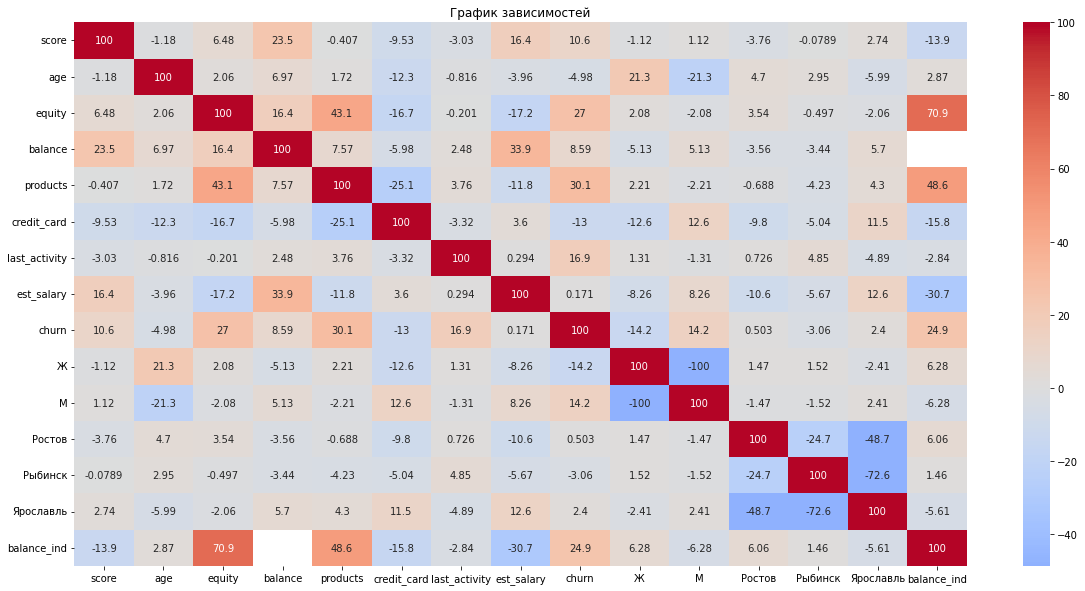

In [12]:
# тепловая карта корреляции между значениями датасета

plt.figure(figsize=(20, 10))
sns.heatmap(data.loc[:, ~data.columns.isin(['user_id', 'city', 'gender'])].corr()*100, 
            annot=True, 
            fmt='.3g', 
            cmap='coolwarm',
            center=0, 
            robust=True
            )
plt.title('График зависимостей')
plt.show()

Заметим довольно сильные взаимосвязи между полем-иникатором заполненности столбца баланса и количеством баллов собственности (70.9% - высокая связь) и количеством продуктов, которыми пользуется клиент (48.6% - слабая связь). Таким образом, можно сделать вывод, что присутствующие в столбце пропуски не случайны (MNAR) и зависят от данных, поэтому их нельзя удалять или заполнять другими значениями: это исказит датасет.

Аналогичные результаты показывает и сводная таблица ниже. Различия в количественных дискретных данных наблюдаются именно по вышеописанным столбцам. 

In [13]:
# расчет медианных значений дискретных показателей по 2 группам данных: с пропущенным балансом и с заполненным

discrete_pivot = data.pivot_table(index='balance_ind',
                                  values=['equity', 'products', 'credit_card', 'last_activity', 'churn'],
                                  aggfunc='median').T
discrete_pivot.columns = ['Баланс пропущен','Баланс заполнен']
discrete_pivot['Разница'] = discrete_pivot['Баланс пропущен'] - discrete_pivot['Баланс заполнен']
discrete_pivot

,Баланс пропущен,Баланс заполнен,Разница
churn,0,0,0
credit_card,1,1,0
equity,0,4,-4
last_activity,1,1,0
products,1,2,-1


### Преобразование типов данных

In [14]:
# В целях использования меньшего объема памяти заменим тип данных float64 в поле "age" на int32

data['age'] = data['age'].astype('int32')

### Проверка на дубликаты

Проверим датасет на наличие неявных дубликатов по столбцу "user_id".

In [15]:
data.loc[data['user_id'].duplicated(keep=False)].sort_values(by='user_id').head(20)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ж,М,Ростов,Рыбинск,Ярославль,balance_ind
1892,116540,883.0,Рыбинск,Ж,55,1,362756.49,3,0,1,175920.48,1,1,0,0,1,0,1
7683,116540,887.0,Ярославль,Ж,38,0,NaN,1,0,1,119247.61,0,1,0,0,0,1,0
4862,117943,855.0,Рыбинск,Ж,32,6,1036832.93,4,1,1,107792.71,1,1,0,0,1,0,1
7531,117943,880.0,Ярославль,Ж,40,0,NaN,1,1,0,137718.93,0,1,0,0,0,1,0
5856,120258,908.0,Рыбинск,Ж,38,4,2213581.63,2,0,1,160327.77,1,1,0,0,1,0,1
5889,120258,905.0,Ярославль,М,30,0,NaN,1,1,1,146427.96,0,0,1,0,0,1,0
1410,123461,829.0,Ярославль,Ж,59,0,96222.44,2,0,1,102771.55,1,1,0,0,0,1,1
8621,123461,934.0,Рыбинск,М,34,0,NaN,2,1,0,291619.27,0,0,1,0,1,0,0
9750,124450,758.0,Рыбинск,Ж,36,0,73574.07,2,0,1,79963.59,0,1,0,0,1,0,1
8151,124450,859.0,Ярославль,Ж,38,6,516811.20,1,1,1,95144.63,1,1,0,0,0,1,1


Заметим, что строки с одинаковыми user_id содержат информацию о разных клиентах: это видно при сопоставлении информации, например, в полях город и пол. Такие строки нельзя ни полностью, ни частично удалять - так мы потеряем часть качественных данных.

Что касается столбца user_id, он не пригодится в дальнейшем анализе, поэтому принято решение удалить его.

In [16]:
try:
    data = data.drop(columns=['user_id'])
except:
    pass

__Промежуточный вывод:__

Исходные данные не были подготовлены для дальнейшего анализа и нуждались в некоторой обработке. Данные содержали в себе пропуски, часть которых была удалена, но другая часть оставлена, так как эти пропуски были признаны неслучайными. Некоторые столбцы были переименованы для удобства использования. Для облегчения датасета вещественный тип данных столбца возраст был преобразован в целочисленный. Для будущего корреляционного анализа качественные величины - город и пол - были закодированы. Данные не содержали явных дубликатов, а неявные дубликаты (повторы в поле user_id) содержали информацию о разных клиентах, поэтому были оставлены в датасете.

## EDA (Exploratory Data Analysis)

### Анализ распределения признаков

Для анализа распределения признаков в разрезе оттока и их влияния на отток необходимо разделить переменные на непрерывные и дискретные, так как они требуют разных подходов к анализу.

In [17]:
# Разделение датасета на 2 в зависимости от типа переменных (непрерывные и дискретные) признака

data_cont = data[['churn', 'age', 'score', 'balance', 'est_salary']]

data_discr = data[['churn', 'equity', 'products', 'credit_card', 'last_activity', 'Ж', 'М', 'Ростов', 'Рыбинск', 'Ярославль', 'balance_ind']]

display(data_cont.head())
data_discr.head()

,churn,age,score,balance,est_salary
0,1,25,850.0,59214.82,75719.14
1,0,37,861.0,850594.33,86621.77
2,0,30,892.0,NaN,107683.34
3,1,51,866.0,1524746.26,174423.53
4,1,34,730.0,174.00,67353.16


,churn,equity,products,credit_card,last_activity,Ж,М,Ростов,Рыбинск,Ярославль,balance_ind
0,1,1,2,0,1,1,0,0,1,0,1
1,0,5,3,1,0,1,0,0,1,0,1
2,0,0,1,1,1,1,0,0,1,0,0
3,1,5,2,0,1,1,0,0,0,1,1
4,1,5,1,1,0,0,1,0,0,1,1


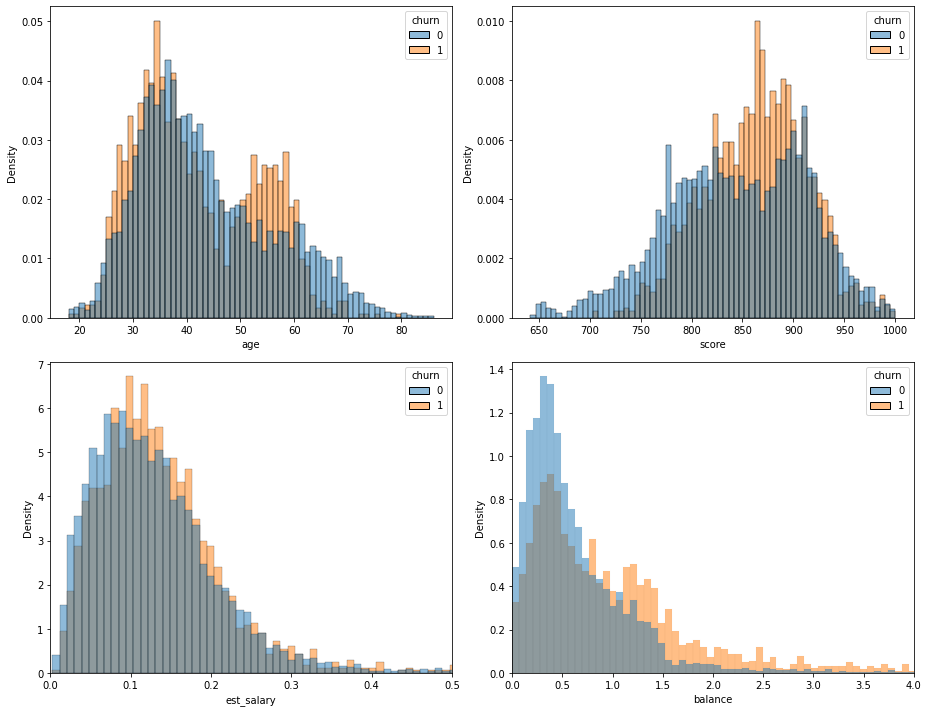

In [18]:
# Визуализируем распределение непрерывных данных, сгруппировав их по факту оттока,
# и выделим интервалы, на которых отток выше лояльности

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 10))

ax1 = sns.histplot(data_cont, 
              x=data_cont['age'], 
              hue=data_cont['churn'],
              stat='density', 
              common_norm=False,
              binwidth=1,
              ax=ax1)

ax2 = sns.histplot(data_cont, 
              x=data_cont['score'], 
              hue=data_cont['churn'],
              stat='density', 
              common_norm=False, 
              bins=70,                   
              ax=ax2)

ax3 = sns.histplot(data_cont, 
              x=data_cont['est_salary']/1000000, 
              hue=data_cont['churn'],
              stat='density', 
              common_norm=False, 
              ax=ax3)
ax3.set_xlim(0, 0.5)

ax4 = sns.histplot(data_cont, 
              x=data_cont['balance']/1000000, 
              hue=data_cont['churn'],
              stat='density', 
              common_norm=False,
              ax=ax4)
ax4.set_xlim(0, 4)

figure.tight_layout()
plt.show()

- На графике распределения по возрасту выделяются две группы клиентов, отток которых выше лояльности: 25 - 37 лет и 50 - 61 лет.
- По распределению скоринговых оценок отток превышает лояльность по клиентам с баллами от 820 до 910 и от 920 до 940.
- На графике оценочного дохода клиентов можно заметить, что отточность начинает превалировать над лояльностью с размера дохода около 70 000 у.e. (0.07 млн), особенно на отрезке данных от 100 до 200 тыс. у.е. Можем сделать предварительный вывод о том, что люди с менее высоким доходом более лояльны к банку.
- Аналогичная тенденция прослеживается и на графике распределения баланса на счете. Отток значительно превышает лояльность на интервале от 1 до 4 млн у.e.

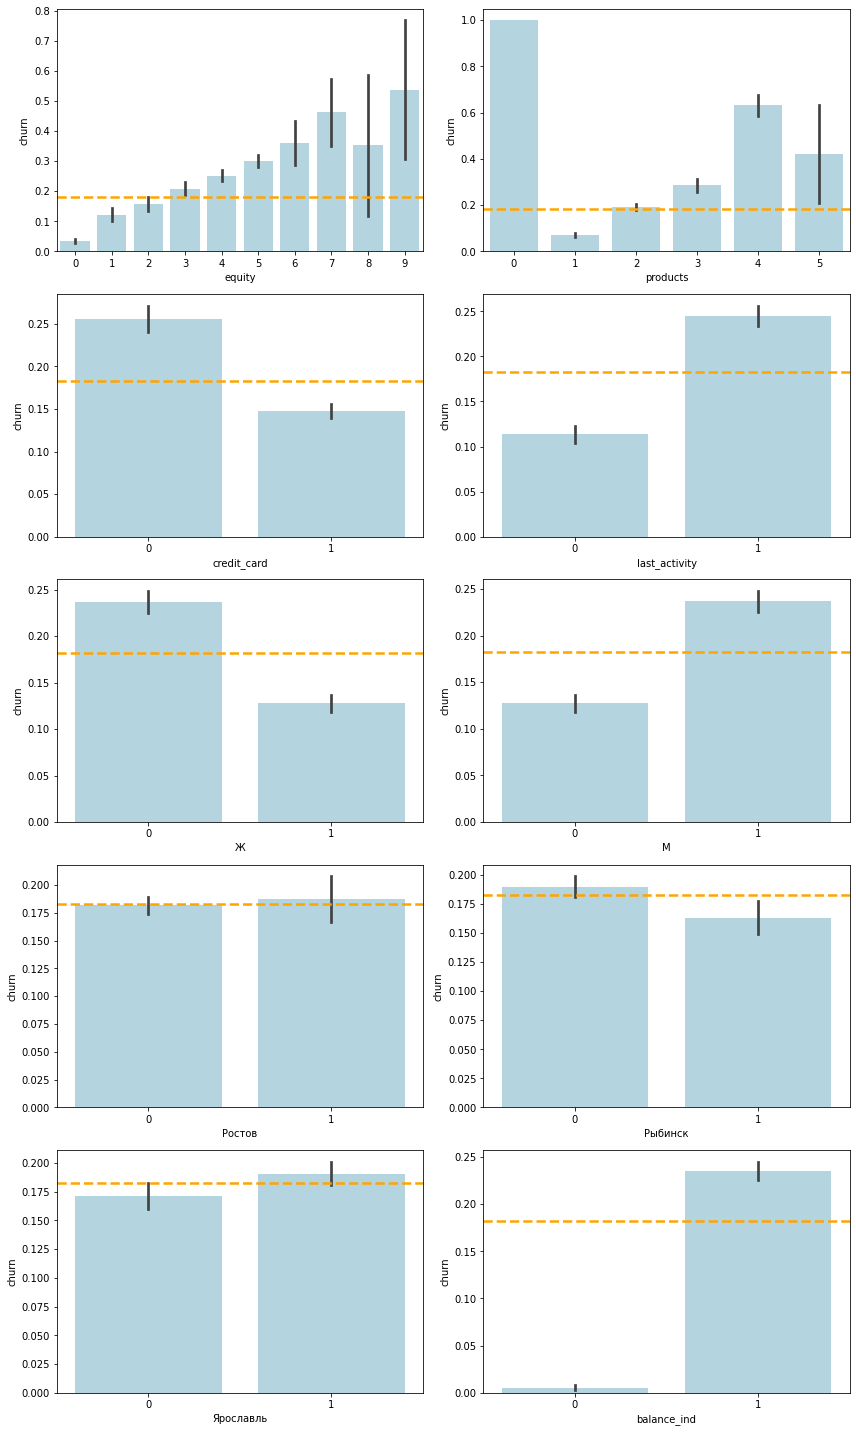

In [19]:
# Визуализируем дискретные величины, чтобы выяснить, какие из них наиболее склонны к оттоку

figure, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 20))

for index, column in enumerate(data_discr.drop(columns=['churn']).columns):
    ax = axes.flatten()[index]
    sns.barplot(x=data_discr[column], 
                y=data_discr['churn'],
                color='lightblue', 
                ax=ax)

    ax.axhline(data['churn'].mean(), 
               color='orange', 
               linestyle='--', 
               linewidth=2.5)
    
figure.tight_layout()     
plt.show()

Кроме того, на графике по количеству банковских продуктов обнаружены клиенты с количеством продуктов, равным 0. Было выяснено, что такой клиент только один, и, вероятно, он попал в датасет случайно. Удалим эту запись.

In [20]:
data.loc[data['products']==0]

,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ж,М,Ростов,Рыбинск,Ярославль,balance_ind
8939,962.0,Рыбинск,Ж,79,3,NaN,0,0,0,25063.96,1,1,0,0,1,0,0


In [21]:
data=data.loc[data['products']!=0]

Отток выше среднего по клиентам со следующими характеристиками:
- баллы собственности клиента 3 и выше;
- от 3 до 5 банковских продуктов;
- отсутствие кредитной карты;
- активность в последний месяц анализа клиента;
- мужской пол;
- город проживания Ростов или Ярославль;
- по клиенту указан баланс.

### Анализ портретов клиентов

In [22]:
# Для анализа мер центральной тенденции признаков разделим признаки на типы величин: непрерывные, дискретные и категориальные

data_cont = data[['churn', 'age', 'score', 'balance', 'est_salary']]

data_discr = data[['churn', 'equity', 'products', 'credit_card', 'last_activity']]

data_cat = data[['churn', 'city', 'gender']]

In [23]:
# Расчет средних значений непрерывных показателей в зависимости от факта оттока

cont_pivot = round(data_cont.pivot_table(index='churn',
                                         values=data_cont.columns,
                                         aggfunc='mean').T, 1)
cont_pivot.columns = ['Лояльность', 'Отток']
cont_pivot['Разница'] = (cont_pivot['Отток'] / cont_pivot['Лояльность'] - 1) * 100
cont_pivot

,Лояльность,Отток,Разница
age,43.0,41.4,-3.720930
balance,733031.6,1134458.2,54.762523
est_salary,147674.6,148357.5,0.462436
score,845.4,863.4,2.129170


In [24]:
# Расчет медианных значений непрерывных показателей в зависимости от факта оттока

discr_pivot = data_discr.pivot_table(index='churn',
                                     values=data_discr.columns,
                                     aggfunc='median').T
discr_pivot.columns = ['Лояльность', 'Отток']
discr_pivot['Разница'] = discr_pivot['Отток'] - discr_pivot['Лояльность']
discr_pivot

,Лояльность,Отток,Разница
credit_card,1,1,0
equity,3,4,1
last_activity,0,1,1
products,2,2,0


In [25]:
# Расчет медианных значений непрерывных показателей в зависимости от факта оттока

cat_pivot = data_cat.pivot_table(index='churn',
                                     values=data_cat.columns,
                                     aggfunc=lambda x: x.mode()).T
cat_pivot.columns = ['Лояльность', 'Отток']
cat_pivot['Разница'] = '-'
cat_pivot

,Лояльность,Отток,Разница
city,Ярославль,Ярославль,-
gender,Ж,М,-


In [26]:
# Объединим полученные сводные таблицы в одну

pd.concat([cont_pivot, discr_pivot, cat_pivot], keys=['discr', 'cont', 'cat'])

Лояльность      Отток    Разница
discr age                 43.0       41.4   -3.72093
      balance         733031.6  1134458.2  54.762523
      est_salary      147674.6   148357.5   0.462436
      score              845.4      863.4    2.12917
cont  credit_card            1          1          0
      equity                 3          4          1
      last_activity          0          1          1
      products               2          2          0
cat   city           Ярославль  Ярославль          -
      gender                 Ж          М          -

In [27]:
data.groupby('churn')['city'].value_counts()

churn  city     
0      Ярославль    4758
       Рыбинск      2246
       Ростов       1151
1      Ярославль    1117
       Рыбинск       436
       Ростов        265
Name: city, dtype: int64

Из полученной таблицы видим, что не для всех признаков меры центральной тенденции значительно отличаются в зависимости от факта оттока. 

Среди усредненных дискретных величин существенная разница наблюдается только по балансу на счете: средний баланс у отточного клиента почти на 55% превышает средний баланс лояльного.

Для отточных клиентов характерно наличие большего количества собственности, а также наблюдается активность в последний месяц лайфтайма.

Чаще среди отточных клиентов встречаются мужчины.

Город проживания отточных и лояльных клиентов один и тот же - Ярославль. Это связано с тем, что в датасете в целом представлено больше записей о клиентах из этого города (возможно, в Ярославле банк пользуется большим спросом, чем в других городах).

Стоит отметить, что аналогичные тенденции уже наблюдались при анализе графиков плотности. 

### Корреляционный анализ

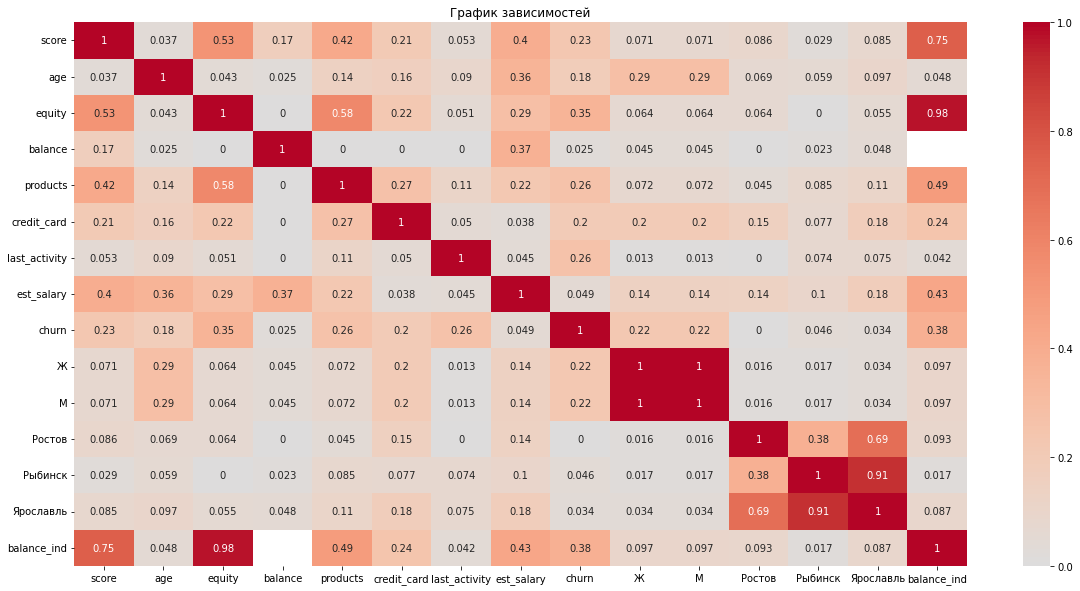

In [28]:
plt.figure(figsize=(20, 10))

sns.heatmap(phik.phik_matrix(df=data.loc[:, ~data.columns.isin(['user_id', 'city', 'gender'])],
                             interval_cols=data_cont.columns),
            annot=True, 
            fmt='.2g', 
            cmap='coolwarm',
            center=0)
plt.title('График зависимостей')
plt.show()

Проанализируем влияние параметров на факт оттока. В матрице корреляций заметно, что сильнее всего на него влияют количество банковских продуктов у клиента (44% - слабая корреляция), количество баллов собственности и заполненность столбца балансом счета клиента (35% и 38%, соответственно, - слабая корреляция). 

Еще более слабая взаимозависимость присутствует между оттоком и активностью клиента (25%) и полом (22%).

Таким образом, корреляционный анализ доказывает присутствие нетесных взаимосязей между некоторыми признаками и признаком оттока.

Проанализируем попарную корреляцию между другими признаками. Между большинством переменных наблюдается очень слабая связь. 

Стоит отметить очень высокую связь между количеством баллов собственности и фактом заполненности столбца баланса (98%). Высокая связь наблюдается между заполненнстью поля баланса и количеством продуктов у клиента и скоринговой оценкой (79% и 75%, соответственно). Связь средней тесноты установилась между скоринговой оценкой и количеством баллов собственности (53%). Также имеет место слабая связь между наличием у клиента кредитной карты и количеством продуктов клиента (44%).

## Проверка статистических гипотез

### Гипотеза  о влиянии дохода на отток клиентов

__H0:__ Различия в доходе клиентов не влияют на их отток. _( = Клиенты уходят из банка вне зависимости от своих доходов)_

__H1:__ Различия в доходе клиентов имеют влияние на их отток. _( = Лояльность клиентов банка связана с их доходами)_

Необходимо проверить, какой тест мы можем использовать для проверки вышеописанных гипотез. Использование t-теста Стьюдента возможно в том числе при условии, что распределение признаков в каждой выборке соответствует нормальному распределению. На графиках ниже видно, что распределения наших выборок похожи на пуассоновскиеу, следовательно, в этом случае нельзя использовать t-критерий Стьюдента.

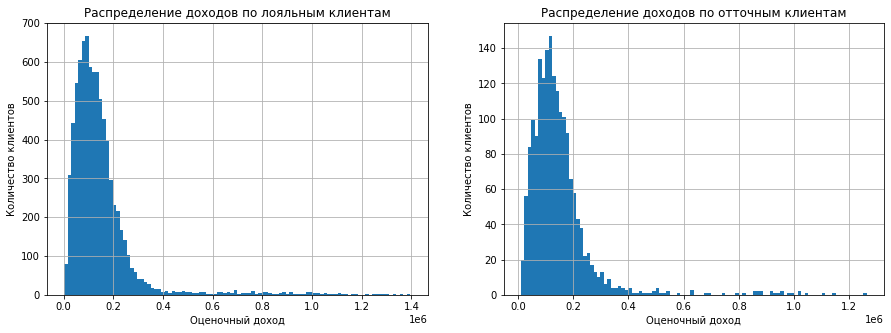

In [29]:
figure, [ax1, ax2] = plt.subplots(1, 2, figsize=(15,5))

ax1 = data.loc[data['churn'] == 0, 'est_salary'].hist(bins=100, ax=ax1)
ax1.set_title('Распределение доходов по лояльным клиентам')
ax1.set_xlabel('Оценочный доход')
ax1.set_ylabel('Количество клиентов')

ax2 = data.loc[data['churn'] == 1, 'est_salary'].hist(bins=100, ax=ax2)
ax2.set_title('Распределение доходов по отточным клиентам')
ax2.set_xlabel('Оценочный доход')
ax2.set_ylabel('Количество клиентов')

plt.show()

In [30]:
sample_1 = data.loc[data['churn'] == 0, 'est_salary']
sample_2 = data.loc[data['churn'] == 1, 'est_salary']

In [31]:
alpha = 0.05
results = st.mannwhitneyu(sample_1, sample_2)
print('p-значение:', results.pvalue)

p-значение: 0.00016830729188229058


In [32]:
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Отвергаем нулевую гипотезу


Гипотеза о том, что клиенты уходят из банка вне зависимости от дохода была отвергнута.

### Гипотеза о влиянии количества банковских продуктов на отток клиентов

__H0:__ Количество банковских продуктов клиента не влияет на факт его оттока

__H1:__ Отток клиента зависит от количества используемых им банковских продуктов

Визуально распределения признака не похожи на нормальные - нельзя использовать t-критерий Стьюдента, используем U-критерий Манна-Уитни.

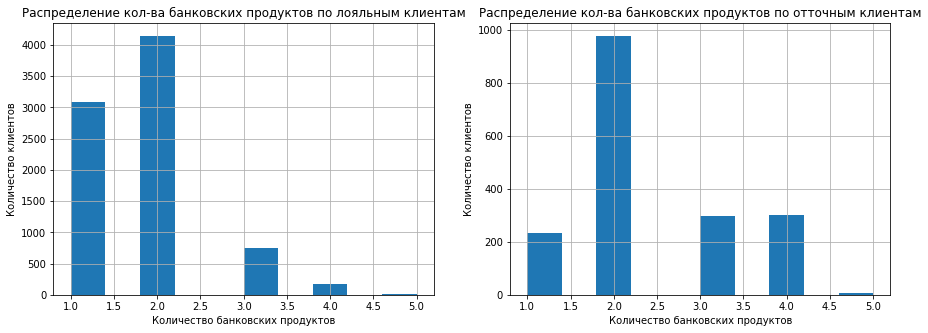

In [33]:
figure, [ax1, ax2] = plt.subplots(1, 2, figsize=(15,5))

ax1 = data.loc[data['churn'] == 0, 'products'].hist(ax=ax1)
ax1.set_title('Распределение кол-ва банковских продуктов по лояльным клиентам')
ax1.set_xlabel('Количество банковских продуктов')
ax1.set_ylabel('Количество клиентов')

ax2 = data.loc[data['churn'] == 1, 'products'].hist(ax=ax2)
ax2.set_title('Распределение кол-ва банковских продуктов по отточным клиентам')
ax2.set_xlabel('Количество банковских продуктов')
ax2.set_ylabel('Количество клиентов')

plt.show()

In [34]:
sample_1 = data.loc[data['churn'] == 0, 'products']
sample_2 = data.loc[data['churn'] == 1, 'products']

In [35]:
results = st.mannwhitneyu(sample_1, sample_2)
print('p-значение:', results.pvalue)

p-значение: 1.1812726611971905e-161


In [36]:
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Отвергаем нулевую гипотезу


По результатам проверки мы не можем принять гипотезу об отсутствии влияния количества банковских продуктов на отточность клиентов.

## Промежуточные итоги

Для дальнейшей сегментации клиентов и выбора сегментов, наиболее склонных к оттоку, соберем выводы, полученные выше в процессе анализа.

В процессе корреляционного анаилза выяснилось, что отток наиболее зависим от количества банковских продуктов у клиента, количество баллов собственности, активностью клиента и полом. Однако стоит отметить, что по шкале Чеддока взаимосвязи факта оттока с вышеперечисленными признаками можно охарактеризовать как слабые и очень слабые.

Далее выяснилось, что медианное количество банковских продуктов у отточных и лояльных клиентов не отличается. Но, исследуя распределение признака, определили, что уходят чаще клиенты с 3-мя и более продуктами. __Характерно высокий отток по клиентам с 4-мя банковскими продуктами.__ Кроме того, при проверке статистической гипотезы о присутствии зависимости между количеством банковских продуктов у клиента было выяснено, что нельзя отрицать отсутствие влияния количества банковских продуктов на отток.

Важно отметить, что кредитными картами чаще пользуются лояльные клиенты: __отток по клиентам без кредитных карт выше.__

Аналогичный вывод был сделан и по количеству баллов собственности (=количество объектов собственности): отток по клиентам с 3-мя и более объектами собственности выше среднего. __Особенно часто уходят клиенты с 7-ю и 9-ю объектами собственности.__

Также было отмечено, что __в среднем мужчины чаще уходят из банка, чем женщины__ - отточность мужчин выше среднебанковской.

Что касается возраста клиентов, анализ графиков плотности показал, что __отток превышает лояльность клиентов в двух возрастных сегментах: 25 - 37 лет и 50 - 61 лет.__ А средний возраст отточных клиентов на 1,5 года меньше аналогичного показателя по лояльным клиентам.

Сделаем выводы о влиянии оценочных доходов и баланса на счетах клиентов. В средем доход клиентов не отличается в зависимости от факта оттока, однако судя по графику плотности __отточность начинает превалировать, но не очень существенно, над лояльностью с размера дохода около 70 000 у.e. (0.07 млн), особенно на отрезке данных от 100 до 200 тыс. у.е.__ Исходя из этого, можем сделать  вывод о том, что люди с менее высоким доходом более лояльны к банку.

Что касается баланса на счете, средний баланс у отточного клиента почти на 55% превышает средний баланс лояльного. На графике плотности видно, что __отток значительно превышает лояльность на интервале от 1 до 4 млн у.e.__, что подтвержает вышепредставленное утверждение. 

Что касается города проживания отточных и лояльных клиентов, и отточные, и лояльные клиенты чаще всего живут в Ярославле, но это объясняется тем фактом, что клиентов банка в Ярославле в целом больше, чем в других городах. Из графиков плотности можно сделать вывод, что __отток выше среднего в Ярославле и Ростове, а в Рыбинске - наоборот, ниже, чем в среднем по банку.__

## Сегментация отточных клиентов

### Выделение сегментов

__Первый сегмент__ - клиенты мужчины с количеством объектов собственности 3 и более. Таких клиентов в датасете 967, что делает этот сегмент самый крупным среди выбранных.

In [37]:
print('Абсолютная величина оттока в сегменте - {}'.format(data.query('gender=="М" & equity>=3 & churn==1')['churn'].count()))
print('Доля оттока в сегменте - {0:.4}%'.format(data.query('gender=="М" & equity>=3 & churn==1')['churn'].count() / data.query('gender=="М" & equity>=3')['churn'].count() * 100))

Абсолютная величина оттока в сегменте - 967
Доля оттока в сегменте - 35.47%


В процессе анализа было выявлено, что баланс на счете у отточного клиента в среднем превышает баланс на счете у лояльного клиента. Выделенный __вторым сегмент__ более многочисленный, чем остальные выбранные сегменты - поэтому стоит сконцентрировать работу специалистов именно на удержании клиентов из этого мегмента. Кроме того логично заметить, что отток клиента с большим остатком на счете для банка будет большей потерей, чем с не такой существенной суммой на счете. Исходя из этого, работа с клиентами с большими суммами на балансе должна являться приоритетной для отдела маркетинга банка.

In [38]:
# Сегмент 1
# Остаток на счете свыше 1 млн у.е. 

print('Абсолютная величина оттока в сегменте - {}'.format(data.query('balance>=1000000 & churn==1')['churn'].count()))
print('Доля оттока в сегменте - {0:.4}%'.format(data.query('balance>=1000000 & churn==1')['churn'].count() / data.query('balance>=1000000')['churn'].count() * 100))

Абсолютная величина оттока в сегменте - 722
Доля оттока в сегменте - 38.55%


__Третий сегмент__ представлен клиентами со средним, по меркам банка, оценочным доходом (от 70 до 200 тыс. у.е.), у которых нет в качестве банковского продукта кредитной карты. Данный сегмент довольно многочислен и, кроме того, общеизвестно, что основную часть своей прибыли банк формирует за счет кредитования. Исходя их этого, имеет место работа с клиентами, еще не кредитующимися в банке.

In [39]:
# Сегмент 2
# Доход - 70 - 200 тыс. у.е., отсутствие кредитной карты

print('Абсолютная величина оттока в сегменте - {}'.format(data.query('est_salary>=70000 & est_salary<=200000 & credit_card==0 & churn==1')['churn'].count()))
print('Доля оттока в сегменте - {0:.4}%'.format(data.query('est_salary>=70000 & est_salary<=200000 & credit_card==0 & churn==1')['churn'].count() / data.query('est_salary>=70000 & est_salary<=200000 & credit_card==0')['churn'].count() * 100))

Абсолютная величина оттока в сегменте - 532
Доля оттока в сегменте - 27.16%


### Приоритизация сегментов

Ранее были выделены 3 сегмента клиентов, удержание которых является первоочередной задачей для отдела маркетинга:
1) мужчины с количеством объектов собственности 3 и более (967 клиентов в датасете, процент оттока в сегменте - 35.47%);

2) клиенты с остатком на счете свыше 1 млн у.е.(722 клиентов в датасете, процент оттока в сегменте - 38.55%);

3) клиенты с оценочным доходом от 70 до 200 тыс. у.е., у которых нет кредитной карты (532 клиентов в датасете, процент оттока в сегменте - 27.16%).

Однако поскольку ресурсы маркетинга ограничены, необходимо приоритизировать эти сегменты и работать с клиентами в соответсвии с их ценностью для банка.

Исходя из размеров долей отточных клиентов в сегментах, можно было бы начать работу с удержания клиентов, составляющих сегмент с самой высокой долей оттока, - с остатком на счете свыше 1 млн у.е. Однако если обратить внимание на долю клиентов, составляющих этот сегмент, среди всех клиентов банка (27.33%) и сравнить ее с аналогичным показателем по клиентам, составляющим 1-й сегмент (мужчины с количеством объектов собственности 3+) (18.78%), а также на отток клиентов в абсолютном выражении, мы увидим, что рациональнее было бы начать работу с удержания клиентов с 1-го сегмента, несмотря на то что доля оттока в этом сегменте на 3% ниже, чем во 2-м.

Следующим этапом маркетологам стоит обратить свои силы на удержание клиентов из 2-го сегмента (клиенты с остатком на счете свыше 1 млн у.е.). Процент оттока по сегменту выше, чем в 3-м сегменте, а доля самого сегмента прктически такая же, как у 3-го.

И наконец стоит обратить на клиентов с оценочным доходом от 70 до 200 тыс. у.е., у которых нет кредитной карты.

In [40]:
print('Доля мужчин с количеством объектов собственности 3+ в датасете - {0:.3}%'.format(data.query('gender=="М" & equity>=3')['churn'].count() / data['churn'].count() * 100))

print('Доля клиентов с остатком на счете свыше 1 млн у.е. в датасете - {0:.3}%'.format(data.query('balance>=1000000')['churn'].count() / data['churn'].count() * 100))

print('Доля клиентов с оценочным доходом от 70 до 200 тыс. у.е. без кредитной карты в датасете - {0:.3}%'.format(data.query('est_salary>=70000 & est_salary<=200000 & credit_card==0')['churn'].count() / data['churn'].count() * 100))  

Доля мужчин с количеством объектов собственности 3+ в датасете - 27.3%
Доля клиентов с остатком на счете свыше 1 млн у.е. в датасете - 18.8%
Доля клиентов с оценочным доходом от 70 до 200 тыс. у.е. без кредитной карты в датасете - 19.6%


## Рекомендации маркетингу

___Список рекомендаций:___


- __По сегменту 1:__ В последнее время банки расширяют ассортимент предоставляемых услуг, в том числе в сторону страхования. Можно предположить, что клиенты-владельцы большого количества имущества пользуются услугами страховых компаний с целью обезопасить свою недвижимость, автомобиль и т.д. Банк мог бы взять на себя функцию страхового агента: клиенту было бы удобно пользоваться услугами банка, который одновременно является и его банком, и страховой компанией. Помимо этого, банк мог бы предложить своим клиентам как банка более выгодные условия страхования с целью повышения лояльности.


- __По сегменту 2:__ В отношение клиентов из 2-го сегмента, с большими остатками на счетах, можно воспользоваться следующими рекомендациями: предлагать клиентами открытие депозитных счетов с повышенными (относительно остальных депозитных продуктов банка) процентами; предлагать клиентам вложение "свободных" денежных средств в торговлю на бирже (трейдинг) с помощью доверительного управителя в лице банка.


- __По сегменту 3:__ Клиентам со средним заработком, не имеющим кредитной карты, из 3-го сегмента имеет смысл предлагать открытие кредитной карты. Однако факт того, что клиент до сих пор не завел себе и не пользуется кредитной картой, вероятно, говорит о том, что она не так привлекает его, по крайней мере по предложенным в настоящее время условиям. Исходя из этого, рациональным будет предложить клиентам новый продукт - карту рассрочки (без платежей в течение первых n дней и с фиксированной невысокой ставкой процента).